In [2]:
# import packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

In [2]:
# import packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channel_first", update the input shape
        if K.image_data_format() == "channel_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding = "same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding = "same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classififer
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

# initialize the list of data and labels

In [3]:
data = []
labels = []

DATASET_PATH = 'dataset3'
MODEL_NAME = 'model.hfinal'

# Prepare dataset

In [4]:
# loop over the input images
for imagePath in sorted(list(paths.list_images(DATASET_PATH))):
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width = 28)
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the label list
    label = imagePath.split(os.path.sep)[-3]
    label = "E" if label == "positives" else "Others"
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype = "float") / 255.0
labels = np.array(labels)

# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels), 2)

# account for skew in the labeled data
classTotals = labels.sum(axis = 0)
classWeight = classTotals.max() / classTotals

# partition the data into training and testing splits using 80% of the data
# for training and remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size = 0.20, stratify = labels, random_state = 42)

# initialize the model

In [5]:
print("[INFO] compiling model...")
model = LeNet.build(width = 28, height = 28, depth = 1, classes = 2)
model.compile(loss = "binary_crossentropy", optimizer = "adam",
    metrics = ["acc"])

[INFO] compiling model...


2022-04-26 15:49:11.667038: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# train the network

In [6]:
print("[INFO] training network...")
classWeight = {0: classWeight[0], 1: classWeight[1]}
H = model.fit(trainX, trainY, validation_data = (testX, testY),
    class_weight = classWeight, batch_size = 64, epochs = 15, verbose = 1)

[INFO] training network...
Epoch 1/15
4/4 [==============================] - 1s 154ms/step - loss: 0.7634 - acc: 0.4890 - val_loss: 0.6863 - val_acc: 0.5439
Epoch 2/15
4/4 [==============================] - 0s 81ms/step - loss: 0.7552 - acc: 0.5463 - val_loss: 0.6880 - val_acc: 0.5789
Epoch 3/15
4/4 [==============================] - 0s 84ms/step - loss: 0.7467 - acc: 0.5330 - val_loss: 0.6990 - val_acc: 0.4561
Epoch 4/15
4/4 [==============================] - 0s 77ms/step - loss: 0.7384 - acc: 0.4890 - val_loss: 0.6792 - val_acc: 0.6140
Epoch 5/15
4/4 [==============================] - 0s 81ms/step - loss: 0.7221 - acc: 0.6916 - val_loss: 0.6686 - val_acc: 0.6316
Epoch 6/15
4/4 [==============================] - 0s 79ms/step - loss: 0.7079 - acc: 0.5903 - val_loss: 0.6748 - val_acc: 0.6491
Epoch 7/15
4/4 [==============================] - 0s 80ms/step - loss: 0.6803 - acc: 0.6432 - val_loss: 0.6627 - val_acc: 0.6491
Epoch 8/15
4/4 [==============================] - 0s 81ms/step - loss

# evaluate the network

In [7]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size = 64)
print(classification_report(testY.argmax(axis = 1),
    predictions.argmax(axis = 1), target_names = le.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

           E       0.59      0.77      0.67        26
      Others       0.74      0.55      0.63        31

    accuracy                           0.65        57
   macro avg       0.66      0.66      0.65        57
weighted avg       0.67      0.65      0.65        57



# save the model to disk

In [8]:
model.save(MODEL_NAME)

2022-04-26 15:49:27.221203: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model.hfinal/assets


# plot the training + testing loss and accuracy

In [3]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, 15), H.history["acc"], label = "acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend()
# plt.savefig(args["plot"])
plt.show()

NameError: name 'H' is not defined

<Figure size 432x288 with 0 Axes>

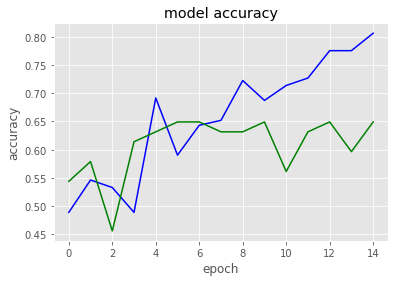

In [10]:
plt.plot(H.history['acc'], 'b')
plt.plot(H.history['val_acc'], 'g')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

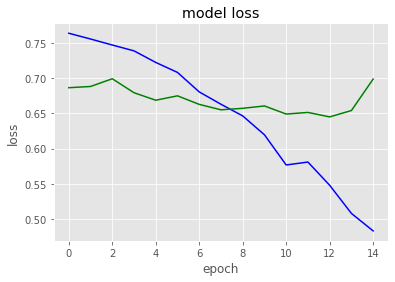

In [11]:
plt.plot(H.history['loss'], 'b')
plt.plot(H.history['val_loss'], 'g')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()